In [1]:
from IPython.core.display import HTML
HTML(r"""
<style>
    .output-plaintext, .output-stream, .output {
        font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif, "Apple Color Emoji", "Segoe UI Emoji", "Segoe UI Symbol" !important;
        line-height: 1.2 !important;
        font-size: 15px !important;
    }
</style>
""")

# 1. 환경 세팅


- 라이브러리 다운로드

```bash
conda create -n gpt python=3.12 -y
conda activate gpt
# https://github.com/explosion/spaCy/issues/13528
conda install "numpy>=1.19.0,<2.0.0" spacy -y  
conda install pytorch::pytorch torchvision torchaudio torchtext -c pytorch -y
conda install matplotlib tensorboard seaborn -y
conda install conda-forge::tiktoken -y
```

- gpu setting


In [2]:
#to define the models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

#to load,iterate and process the dataset
import torchtext

#to visualize loss plots on localhost while training
# See https://pytorch.org/docs/stable/tensorboard.html for more details
from torch.utils.tensorboard import SummaryWriter

In [3]:
torch.__version__, torchvision.__version__, torchtext.__version__

('2.3.1', '0.18.1', '0.6.0')

In [5]:

import spacy
import random
import numpy as np



from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_theme()

In [6]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def setup_device():
    device = get_device()
    print(f"Using device: {device}")

    if device.type == "cuda":
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
        torch.cuda.empty_cache()
    elif device.type == "mps":
        print("Using MPS (Metal Performance Shaders) on Mac")
    else:
        print("Using CPU")
    return device

# 사용 예시
device = setup_device()

Using device: mps
Using MPS (Metal Performance Shaders) on Mac


In [7]:
BATCH_SIZE = 128
SEED = 1024

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


# Attention is all you need

지금부터 "Attention is all you need" 논문을 총 9가지 단계로 하나하나 개발해보도록 하겠습니다.


![](./imgs/arch.png)


저희는 Transformer 모델을 크게 7가지로 쪼개서 개발해보도록 하겠습니다. 이후 Train, Evaluation까지 확인해보겠습니다.


![](./imgs/transformer_arch.png)


1. Tokenize
2. Embedding
3. Masking
    1. padding mask
    2. look ahead mask
4. Positional Encoding
5. Encoder
    - MHSA
    - FFN
    - LayerNorm
6. Decoder
7. Transformer
8. Train
9. Evaluation

# 1. Tokenize

토크나이즈의 핵심은 string 타입의 텍스트들을 word 또는 subword로 쪼개어 token화 시켜주고, 각 token들에 int index를 매핑시켜주는 것입니다.

Transformer 논문은 `WMT 2014 English-to-German translation`, 데이터를 사용해 영어를 독일어로 번역하는 태스크를 수행하였습니다. 
이를 위해 저희도 

1. 영어 / 독일어 데이터(Multi30k)를 다운 받고
2. word, subword로 token화 시켜주는 tokenizer로 tokenize 시켜주고
3. train / validation / test 데이터를 분리시키는 작업

위 3가지 작업을 수행하겠습니다.


In [8]:
import os

def load_tokenizers():
    # Download tokenizer from spacy
    try:
        spacy_de = spacy.load("de_core_news_sm") # german
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm") # english
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en


spacy_de, spacy_en = load_tokenizers()

In [9]:
def tokenize_english(eng_text):
    return [token.text for token in spacy_en.tokenizer(eng_text)]

def tokenize_german(german_text):
    return [token.text for token in spacy_de.tokenizer(german_text)]

print(tokenize_english('I wish you all the best'))
print(tokenize_german('Ich wünsche Ihnen alles Gute'))

['I', 'wish', 'you', 'all', 'the', 'best']
['Ich', 'wünsche', 'Ihnen', 'alles', 'Gute']


#### `torchtext.data.Field`

- `lower`: 텍스트를 소문자로 변환할지 여부를 지정합니다.
- `batch_first`: 배치 차원을 첫 번째로 하는 텐서를 생성할지 여부를 지정합니다.


또한 transformer의 encoder에 들어갈 input인 `source`, output인 `target`을 독일어 -> 영어로 지정합니다.

- `source`: german
- `target`: english

In [10]:
from torchtext.data import Field

UNK = '<unk>' # 0
PAD = '<pad>' # 1
SOS = '<sos>' # 2
EOS = '<eos>' # 3

source_process_pipeline = Field(tokenize = tokenize_german,
                       init_token = SOS,
                       eos_token = EOS,
                       pad_token= PAD,
                       unk_token=UNK,
                       lower = True,
                       batch_first = True)
target_process_pipeline = Field(tokenize = tokenize_english,
                       init_token = SOS,
                       eos_token = EOS,
                       pad_token= PAD,
                       unk_token=UNK,
                       lower = True,
                       batch_first = True)

## [Multi30k](https://pytorch.org/text/stable/datasets.html#multi30k)

이제 Multi30k 독일어-영어 번역 작업을 사용한 실제 예제를 살펴보겠습니다. 이 작업은 논문에서 다룬 WMT 작업(대규모 기계 번역 task)보다 훨씬 규모가 작지만, 여전히 전체 시스템을 잘 보여줄 수 있습니다.


In [11]:
# https://github.com/pytorch/text/issues/1756
from torchtext.datasets import Multi30k

Multi30k.urls = [
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt_task1_test2016.tar.gz",
]

train_data, validation_data, test_data = Multi30k.splits(exts = ('.de','.en'),
                                                       fields = (source_process_pipeline,
                                                                target_process_pipeline))

In [12]:
source_process_pipeline.build_vocab(train_data,min_freq=2)
target_process_pipeline.build_vocab(train_data,min_freq=2)

print(len(source_process_pipeline.vocab))
print(len(target_process_pipeline.vocab))

7853
5893


In [13]:
print(list(source_process_pipeline.vocab.stoi.items())[:20])
print(list(target_process_pipeline.vocab.stoi.items())[:20])


[('<unk>', 0), ('<pad>', 1), ('<sos>', 2), ('<eos>', 3), ('.', 4), ('ein', 5), ('einem', 6), ('in', 7), ('eine', 8), (',', 9), ('und', 10), ('mit', 11), ('auf', 12), ('mann', 13), ('einer', 14), ('der', 15), ('frau', 16), ('die', 17), ('zwei', 18), ('einen', 19)]
[('<unk>', 0), ('<pad>', 1), ('<sos>', 2), ('<eos>', 3), ('a', 4), ('.', 5), ('in', 6), ('the', 7), ('on', 8), ('man', 9), ('is', 10), ('and', 11), ('of', 12), ('with', 13), ('woman', 14), (',', 15), ('two', 16), ('are', 17), ('to', 18), ('people', 19)]


### Tokenizer 바꿔보기

앞서 가져온 spacy의 tokenizer는 단어기반으로 tokenize를 하는 방식입니다. 이 방식의 가장 큰 문제점은, 

1. 신조어들을 잘 처리할 수 없다는 것
2. 뭐해, 뭐함, 뭐를... 같은 비슷한 단어를 다르게 파악합니다.

이를 해결하기 위해서 subword 기반의 tokenizer가 주로 사용되고 있으며, 저는 openai의 `tiktoken`을 사용해보겠습니다.

- [확인해보기](https://tiktokenizer.vercel.app/?model=o200k_base)

![](./imgs/tiktoken.png)

위의 링크를 통해서 문장들이 어떻게 tokenize되는지 live로 확인할 수 있습니다.

저희는 여기서 `o200k_base` encoder를 사용해보겠습니다. 이 인코더는 참고로 현재 기준(24.07.08) 가장 최신인 `gpt-4o`에서 사용되고 있습니다.


In [14]:
import tiktoken

encoding = tiktoken.get_encoding("o200k_base")

# pytorch text의 multi30k가 사용할 수 있도록 변형
def tokenize(text: str) -> list[str]:
    bytes_list = encoding.decode_tokens_bytes(encoding.encode(text))
    return [b.decode('utf-8') for b in bytes_list]


print(tokenize('I wish you all the best'))
print(tokenize('Ich wünsche Ihnen alles Gute'))

['I', ' wish', ' you', ' all', ' the', ' best']
['Ich', ' wünsche', ' Ihnen', ' alles', ' Gute']


이제 바뀐 tokenizer로 앞전에 했던 코드들에 적용해주겠습니다.

In [15]:
from torchtext.data import Field

UNK = '<unk>' # 0
PAD = '<pad>' # 1
SOS = '<sos>' # 2
EOS = '<eos>' # 3

source_process_pipeline = Field(tokenize = tokenize,
                       init_token = SOS,
                       eos_token = EOS,
                       pad_token= PAD,
                       unk_token=UNK,
                       lower = True,
                       batch_first = True)
target_process_pipeline = Field(tokenize = tokenize,
                       init_token = SOS,
                       eos_token = EOS,
                       pad_token= PAD,
                       unk_token=UNK,
                       lower = True,
                       batch_first = True)


from torchtext.datasets import Multi30k

Multi30k.urls = [
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt_task1_test2016.tar.gz",
]

train_data, validation_data, test_data = Multi30k.splits(exts = ('.de','.en'),
                                                       fields = (source_process_pipeline,
                                                                target_process_pipeline))

source_process_pipeline.build_vocab(train_data,min_freq=2)
target_process_pipeline.build_vocab(train_data,min_freq=2)

print(len(source_process_pipeline.vocab))
print(len(target_process_pipeline.vocab))

6623
6658


In [16]:
list(target_process_pipeline.vocab.stoi.items())[:50]

[('<unk>', 0),
 ('<pad>', 1),
 ('<sos>', 2),
 ('<eos>', 3),
 (' a', 4),
 ('.', 5),
 ('a', 6),
 (' in', 7),
 (' the', 8),
 (' on', 9),
 (' is', 10),
 (' and', 11),
 (' man', 12),
 (' of', 13),
 (' with', 14),
 (',', 15),
 (' woman', 16),
 (' are', 17),
 (' to', 18),
 ('two', 19),
 (' at', 20),
 (' wearing', 21),
 (' people', 22),
 (' shirt', 23),
 (' white', 24),
 (' young', 25),
 (' black', 26),
 (' his', 27),
 (' an', 28),
 (' while', 29),
 (' blue', 30),
 (' red', 31),
 (' sitting', 32),
 (' girl', 33),
 (' dog', 34),
 (' boy', 35),
 (' standing', 36),
 (' men', 37),
 (' playing', 38),
 (' group', 39),
 (' street', 40),
 (' down', 41),
 (' walking', 42),
 (' front', 43),
 (' her', 44),
 (' holding', 45),
 (' water', 46),
 (' by', 47),
 ('the', 48),
 ('an', 49)]

독일어는 7853 -> 6623로 줄어들었고,
영어는 5893 -> 6658로 커졌습니다.

### [Bucket Iterator](https://torchtext.readthedocs.io/en/latest/data.html?highlight=bucket#bucketiterator)

Pytorch의 dataloader와 비슷한 역할을 한다. 하지만 dataloader 와 다르게 비슷한 길이의 문장들끼리 
batch를 만들기 때문에 padding의 개수를 최소화할 수 있다. 내부적으로 [torchtext.data.pool](https://torchtext.readthedocs.io/en/latest/data.html?highlight=bucket#bucketiterator)을 사용합니다.

In [19]:
from torchtext.data import BucketIterator

train_iterator, validation_iterator, test_iterator = BucketIterator.splits(
    (train_data, validation_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

In [21]:
len(train_iterator), len(validation_iterator), len(test_iterator)

(227, 8, 8)

지금까지 저희는 string으로 주어지는 german(de), english(en) 문장들을 openai의 tiktoken을 사용해 subword로 분리시켰으며, 분리된 subword들을 각각 index인 int로 매핑 시켰습니다. 

이후 학습을 위해 BucketIterator를 사용해, 비슷한 문장길이들끼리 batch를 만들어 train, validation, test 데이터셋을 마련하였습니다.

다음으로 이 int로 매핑된 token들을 word embedding으로 처리하여, token간의 상관관계를 계산할 수 있도록 만들어보겠습니다.

# 2. 임베딩

1단계의 tokenize를 통해 문장을 List[int]로 변경하여, 최종적으로 아래와 같은 데이터를 만들었습니다.

- Sources (BATCH_SIZE, 배치단위로 패딩된 문장)
- Target (BATCH_SIZE, 배치단위로 패딩된 문장)

이제 이 입력값들을 받아들일 word embedding을 만들어보도록 하겠습니다.


"Attention is all you need" 논문의 3.4 Embeddings and Softmax

> *We use learned embeddings to convert the input tokens and output tokens to vectors of dimension dmodel.*  

Attention논문은 pretrained model이 아닌 모델 학습 과정에서 학습된 learned embeddings을 사용했습니다.

> *we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation ...

임베딩 레이어와 decoder 위에 존재하는 linear + softmax 레이어의 linear에서 동일한 embedding을 share 했다고 합니다.

또한 embedding을 총 3곳에서 share해서 사용해주었습니다. 

![](./imgs/embedding.png)

> *In the embedding layers, we multiply those weights by √dmodel.*

마지막으로 embedding layer의 weight를 √dmodel로 스캐일해주었습니다.


In [27]:
import math

class Embedding(nn.Module):
    def __init__(self, vocab: int, d_model: int):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

# Test
embed = Embedding(60000, 512)  # 60000단어, 512 embedding dimension
encoding = tiktoken.get_encoding("o200k_base")
encoded = encoding.encode("I love you") # [40, 3047, 481]
print(encoded)

# 임베딩된 결과
result = embed(torch.LongTensor(encoded))
print(result.shape)
result

[40, 3047, 481]
torch.Size([3, 512])


tensor([[ 4.5680e+01,  2.5295e+01, -1.3905e+01,  ...,  3.2018e+01,
          1.0669e+01,  2.2317e+01],
        [ 6.3884e+00,  7.8825e+00,  1.8101e+01,  ..., -3.6578e+01,
         -1.4883e+01, -1.3742e+01],
        [-2.0093e-02, -8.1925e+00, -1.2971e+01,  ..., -6.2918e+00,
         -2.5926e+01, -3.6113e+01]], grad_fn=<MulBackward0>)

# 3. Masking

Transformer에서는 총 2가지 종류의 masking을 사용합니다.


1. padding mask
2. look-ahead mask (또는 causal mask라고도 불림)

이때 source(input)과 target(output)이 사용하는 mask는 다음과 같습니다.

1. source = padding_mask
2. target = padding_mask & look_ahead_mask


1. Padding 마스크:
    - 목적: 배치 처리를 위해 추가된 패딩 토큰을 무시하도록 합니다.
    - 적용: Source(인코더 입력)와 Target(디코더 입력) 모두에 적용됩니다.
2. Look-ahead 마스크:
    - 목적: 미래의 토큰 정보를 가려 자기회귀 속성을 유지합니다.
    - 적용: Target(디코더 입력)에만 적용됩니다.


In [32]:
# 2는 단어, 1은 pad값
torch.tensor([[2., 2., 2., 2., 1., 1., 1.],
        [2., 2., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 1.]])

# padding mask
torch.tensor([[[ True,  True,  True,  True, False, False, False]],
        [[ True,  True, False, False, False, False, False]],
        [[ True,  True,  True,  True,  True,  True, False]]])


# look ahead mask
sentence = "나는 학교에 간다"
encoded = encoding.encode(sentence) # [102052, 136975, 3107, 53736, 2276] 
print(encoded)

# Look-ahead mask: (5, ) -> (5, 5)
torch.tensor([
        [True, False, False, False, False],
        [True, True, False, False, False],
        [True, True, True, False, False],
        [True, True, True, True, False],
        [True, True, True, True, True],
    ])

[102052, 136975, 3107, 53736, 2276]


tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]])

**기억해야 할 점은 look ahead mask는 차원이 하나 더 늘어난 다는 점입니다. 이 때문에 padding_mask 또한 동일한 형태를 가져가지 위해서 차원을 하나 더 더해줍니다.**

또한 현재 우리는 batch 단위로 max_len가 다르기 때문에, 배치단위로 mask의 seq_len (문장 길이)도 달라져야합니다.

In [40]:
def get_padding_mask(seq: torch.Tensor, pad_idx: int) -> torch.Tensor:
    # (batch_size, max_seq_len) -> (batch_size, 1, max_seq_len)
    return (seq != pad_idx).unsqueeze(-2)


def get_look_ahead_mask(trg) -> torch.Tensor:
    # (batch_size, max_seq_len) -> (batch_size, max_seq_len, max_seq_len)
    batch_size, seq_len = trg.size()
    look_ahead_mask = (
        1 - torch.triu(torch.ones(1, seq_len, seq_len, device=trg.device), diagonal=1)
    ).bool()

    # torch.tril(torch.ones((target_length,target_length), device = self.device)).bool()
    return look_ahead_mask


# Test
pad_idx = 0
seq = torch.tensor([[1, 2, 3, 0, 0], [4, 5, 0, 0, 0], [6, 7, 8, 9, 0]])
print(seq.shape)

print("Padding mask 테스트============")
padding_mask = get_padding_mask(seq, pad_idx)
print(padding_mask.shape)
print(padding_mask)

print("Look-ahead mask 테스트============")
look_ahead_mask = get_look_ahead_mask(seq)
print(look_ahead_mask.shape)
print(look_ahead_mask)

print("결합된 마스크 (padding + look-ahead) 테스트============")
target_mask = padding_mask & look_ahead_mask
print(target_mask.shape)
print(target_mask)


torch.Size([3, 5])
Padding mask 테스트============
torch.Size([3, 1, 5])
tensor([[[ True,  True,  True, False, False]],

        [[ True,  True, False, False, False]],

        [[ True,  True,  True,  True, False]]])
Look-ahead mask 테스트============
torch.Size([1, 5, 5])
tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])
결합된 마스크 (padding + look-ahead) 테스트============
torch.Size([3, 5, 5])
tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True, False, False]],

        [[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True, False, False, False],
         [ True

# 4. Positional Encoding

Transformer 모델에서의 Positional Encoding은 순서 정보를 모델에 주입하는 핵심 요소입니다. RNN과 달리 Transformer는 재귀적 구조를 사용하지 않기 때문에, 이 방법을 통해 시퀀스 내 단어의 위치 정보를 제공합니다.

1. **차원**: 임베딩과 동일한 d_model 차원을 가짐
2. **적용 방식**: 임베딩에 단순히 더해짐
3. **구조**: sin과 cos 함수의 조합으로 구성

## 수학적 정의

Positional Encoding (PE)는 다음과 같이 정의됩니다:

```
PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```

여기서:
- `pos`: 시퀀스 내 단어의 위치
- `i`: 임베딩 차원의 인덱스
- `d_model`: 모델의 임베딩 차원

## 주요 특성

1. **고정된 패턴**: 학습 없이 미리 계산 가능
2. **주기성**: sin과 cos 함수의 사용으로 주기적 패턴 형성
3. **상대적 위치 인코딩**: 절대적 위치가 아닌 상대적 위치 정보 제공
4. **선형 결합 가능**: 임베딩에 더해져 쉽게 통합

## 장점

1. **무한한 시퀀스 길이**: 이론적으로 무한한 길이의 시퀀스에 적용 가능
2. **Extrapolation**: 학습 시 보지 못한 길이의 시퀀스에도 적용 가능
3. **계산 효율성**: 미리 계산하여 저장 가능, 실시간 계산 부담 감소

Positional Encoding은 Transformer 모델에 순서 정보를 효과적으로 주입하는 핵심 요소입니다. 단순하면서도 강력한 이 방법은 모델이 시퀀스의 구조를 이해하는 데 중요한 역할을 합니다.

torch.Size([256, 32, 250])


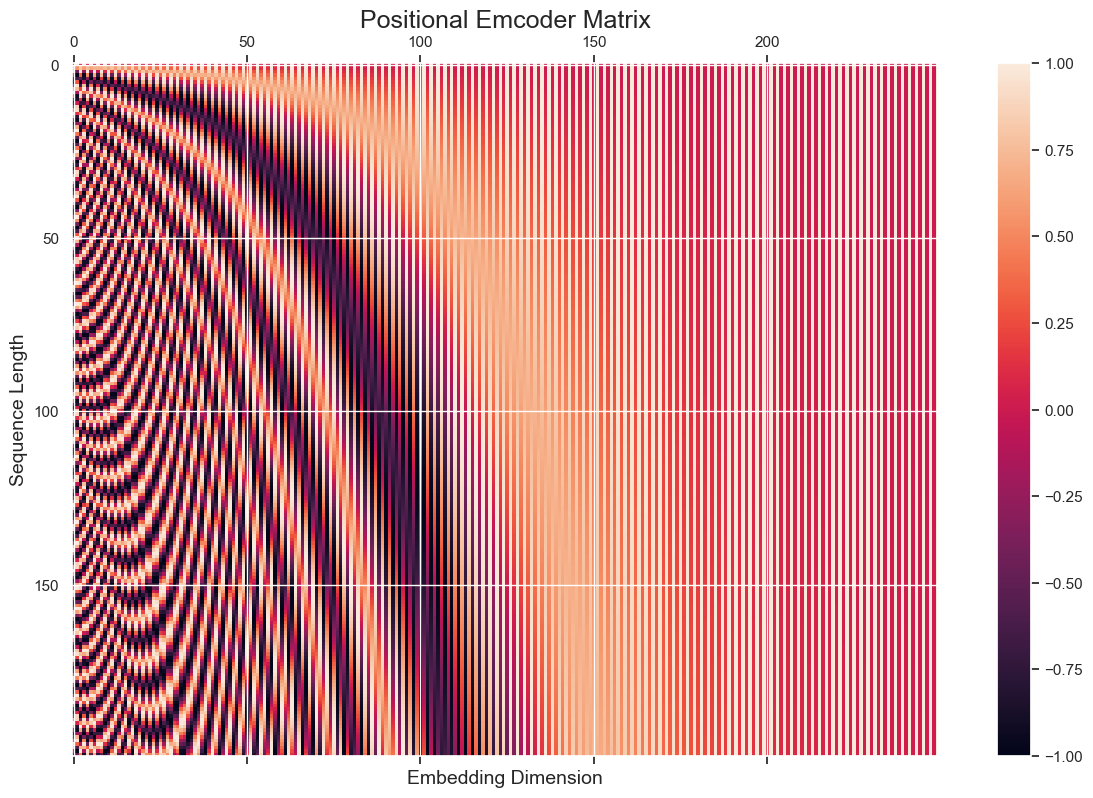

In [45]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_seq_len=200):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, : x.size(1)].clone().detach()


## Test
d_model = 250
pe = PositionalEncoding(d_model)
# (batch, seq_len, d_model)
print(pe(torch.Tensor(np.random.rand(256, 32, d_model))).shape)


# Visualization
fig, ax = plt.subplots(figsize=(15, 9))
cax = ax.matshow(pe.pe.squeeze(0))
fig.colorbar(cax)
ax.set_title('Positional Emcoder Matrix', fontsize=18)
ax.set_xlabel('Embedding Dimension', fontsize=14)
_ = ax.set_ylabel('Sequence Length', fontsize=14)


# 5. Encoder

논문 3.1 내용을 토대로 Encoder 스펙을 정리해보겠습니다.

> The encoder is composed of a stack of N = 6 identical layers.

`Encoder`는 6개의 layer로 동일한 layer로 구성되어있다.

> Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

각 layer는 2개의 `sublayer`로 구성되어있다.

1. multi-head self-attention (`MHSA`)
2. position-wise fully connected feed-forward network (`FFN`)

> We employ a residual connection [10] around each of the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is `LayerNorm(x + Sublayer(x))`, where Sublayer(x) is the function implemented by the sub-layer itself.

모든 sublayer의 output은 아래 수식이 적용되어야 한다. Input x가 주어질때:

1. `Residual Connection`: `x + sublayer(x)`
2. `LayerNorm(1번결과)`

또한 해당 논문의 5.4 Regularization을 살펴보면 아래 구절이 존재합니다.

> Residual Dropout We apply dropout [27] to the output of each sub-layer, before it is added to the sub-layer input and normalized.... For the base model, we use a rate of Pdrop = 0.1.

즉 정리하면 모든 sublayer들은(decoder도 마찬가지로) 최종적으로 다음 수식을 따릅니다. `LayerNorm(x + Dropout(Sublayer(x)), 0.1)`

> In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.


@TODO...?


> To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmodel = 512.

모든 output dimension `d_model`은 512이다.

이외에도 encoder는 `padding mask`를 사용하여, padding으로 채워진 쓰래기 값은 attention에 고려하지 않습니다.

In [22]:
import copy


def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    def __init__(self, layer, N = 6):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, padding_mask):
        for layer in self.layers:
            x = layer(x, padding_mask)
        return self.norm(x)

`Encoder`는 6개의 identical한 sublayer로 구성되어있으며, padding_mask를 사용하여 학습합니다.

# 6. Decoder

> The decoder is also composed of a stack of N = 6 identical layers

`Decoder`는 6개의 동일한 layer로 구성되어있다.

> In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.

디코더의 각 layer는 3개의 sublayer로 구성되어있다.

1. Masked multi-head self-attention (`Masked MHSA`)
2. Position-wise fully connected feed forward network (`FFN`)
3. **Encoder-Decoder attention**

> Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

모든 sublayer는 input x에 대해서 `LayerNorm(x + Sublayer(x))`를 수행해야 한다.

> We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

디코더의 마스킹은 encoder가 사용하는 `padding mask`과 `Look-ahead masking`을 결합하여 사용합니다. 룩어헤드 마스크를 통해서 디코더는 현재 위치(i)가 다음 토큰을 생성할 때, `[i+1:]`에 존재하는 토큰들을 참조하지 않도록 합니다.

이런 학습을 통해서, 학습이 끝난 뒤 실제 inference(추론)할 때와 같은 환경을 조성할 수 있습니다. 추론시에는 정답지 없이 모델이 미래 토큰들을 만들어야 하기 때문입니다.

# 7. Transformer


In [56]:
class Transformer(nn.Module):

    def __init__(
        self,
        encoder,
        decoder,
        source_pad_idx,
        target_pad_idx,
        device,
    ):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.source_pad_index = source_pad_idx
        self.target_pad_index = target_pad_idx
        self.device = device

    # Source mask = padding mask
    def get_source_mask(self, source):
        # source  = (bsize, source_len)
        # 0: pad, 1: value
        source_mask = source != self.source_pad_index

        # unsqueeze(i) operation adds an i_th dimension to the item
        source_mask = source_mask.unsqueeze(1)  # (bsize,1,source_len)
        source_mask = source_mask.unsqueeze(2)  # (bsize,1,1,source_len)

        # source_mask will be applied after calculating-
        # the attention which has 4 dimensions (bsize,n_attn_heads,qlen,klen)
        return source_mask

    # Target mask = padding mask + look-ahead mask
    def get_target_mask(self, target):
        # target = (bsize,target_len)
        target_length = target.shape[1]
    
        # (bsize,1,1,target_len)
        target_pad_mask = (target != self.target_pad_index).unsqueeze(1).unsqueeze(2)

        # tril = 행렬의 하부 삼각 부분
        target_subsequent_mask = torch.tril(
            torch.ones((target_length, target_length), device=self.device)
        ).bool()  # (target_len, target_len)

        return target_subsequent_mask & target_pad_mask  # (bsize,1,tlen,tlen)

    def forward(self, source, target):
        # source = (bsize,slen)
        # target = (bsize,tlen)

        source_mask = self.get_source_mask(source)  # (bsize,1,1,slen)
        target_mask = self.get_target_mask(target)  # (bsize,1,tlen,tlen)

        encoder_output = self.encoder(source, source_mask)  # (bsize,slen,hdim)
        decoder_output, decoder_attention = self.decoder(
            target,
            encoder_output,
            source_mask,
            target_mask,
        ) 
        # decoder_output = (bsiz,tlen,output_dim)
        # decoder_attention = (bsize,num_attn_heads,tlen,slen)
        return decoder_output, decoder_attention


In [26]:
import torch
from torch import nn
from torch.nn.functional import log_softmax


class Transformer(nn.Module):
    def __init__(self, encoder, decoder, i_embed, o_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.i_embed = i_embed
        self.o_embed = o_embed
        self.generator = generator # LinearSoftmax

    def forward(self, inp, oup, in_mask, out_mask):
        """
        Args:
            in_mask (Tensor): Padding mask applied to the input sequence
            out_mask (Tensor): Look-ahead mask applied to the output sequence
        """
        enc_output = self.encoder(self.i_embed(inp), in_mask)
        self.decoder(
            self.o_embed(oup), out_mask, # masked attention return is Q
            enc_output, in_mask # K, V
        )

# Last layer
class LinearSoftmax(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(LinearSoftmax, self).__init__()
        # (... ,in) -> (..., out)
        self.proj = nn.Linear(in_features=d_model, out_features=vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1) # out dim(vocab)에 대해서 softmax


## log_softmax
> https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax

### 1. log_softmax 사용하는 이유

1. 단조 함수 (monotonic function)
Softmax 함수를 통해 입력 벡터를 확률 분포로 변환한 후, 이 확률 분포에서 가장 높은 값을 가지는 요소, 즉 "max값"을 알아내고자 합니다. 이때 softmax 함수의 결과에 log를 취하면, max값을 찾는 과정에서 변화가 없습니다. 왜냐하면 log 함수는 monotonic한 함수이기 때문에 입력 값의 순서를 유지하며, softmax의 결과에서 가장 큰 값이었던 요소는 log를 취해도 여전히 가장 큰 값으로 남아 있습니다.

2. overflow 방지
또한, log를 취함으로써 얻는 이점 중 하나는 수치적 안정성입니다. softmax 함수는 지수 함수를 포함하므로, 입력 값이 크면 결과값도 매우 크게 증가할 수 있습니다. 
이때 $e^\infty$ 인 경우 numpy float으로 표현할 수 있는 값을 넘어갈 수 있어 overflow가 발생할 수 있습니다. 이를 방지하기 위해서 pytorch에서는 `log_softmax()`, `logsumexp()`를 제공합니다.

따라서 log(softmax) 함수는 softmax의 확률 값을 변환하되, 확률 분포에서의 max값을 유지하며, 수치적으로 안정성이 더 좋은 결과를 제공하는 함수로 사용될 수 있습니다.

다음으로 어떻게 log_softmax가 exp를 안정적으로 계산하여, overflow를 방지하고 있는지를 살펴보도록 하겠습니다.

로그를 취하면 큰 값이 덧셈으로 변환되므로 수치적으로 안정한 계산이 가능합니다.


## 2. log\_softmax 수식

log\_softmax 함수는 주어진 벡터 $\mathbf{x} = [x_1, x_2, \ldots, x_n]$에 대해 pytorch에서는 다음과 같이 계산됩니다:

$$
\text{log\_softmax}(x_i) = x_i - c - \log \left( \sum_{j=1}^{n} e^{x_j - c} \right)
$$

이때 $c$는 벡터 $ \mathbf{x} $의 최대값이라고 정의합니다.

$ c = \max(x_1, x_2, \ldots, x_N) $

c를 빼줌으로써, $e^\text{매우큰수}$ 인 경우를 배제하여 overflow를 방지할 수 있습니다. 

그럼 이제 위의 수식이 어떻게 나오게 되었는지 아래에서 확인 해보겠습니다.


### 원래의 소프트맥스 수식

소프트맥스 함수는 다음과 같이 정의됩니다:

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
$$

### 로그 소프트맥스

소프트맥스 함수의 출력에 로그를 취하면 다음과 같습니다:

$$
\log \left( \text{softmax}(x_i) \right) = \log \left( \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}} \right)
$$

로그의 성질을 이용하여 분자와 분모를 분리하면:

$$
\log \left( \text{softmax}(x_i) \right) = \log(e^{x_i}) - \log \left( \sum_{j=1}^{n} e^{x_j} \right)
$$

이는 다음과 같이 단순화됩니다:

$$
\log \left( \text{softmax}(x_i) \right) = x_i - \log \left( \sum_{j=1}^{n} e^{x_j} \right)
$$

하지만 여전히 뒤에, exp(x)에서 x가 무한히 클 경우 overflow가 발생할 수 있습니다. 이렇게 뒤쪽에 있는 log sum exp를 pytorch에서는 [torch.logsumexp](https://pytorch.org/docs/stable/generated/torch.logsumexp.html)로 구현해주고 있으며, 아래와 같이 trick을 사용해서 계산합니다.

### logsumexp

`logsumexp`를 구현해주기 위해서, 먼저, $ c $를 벡터 $ \mathbf{x} $의 최대값이라고 정의합니다:

$ c = \max(x_1, x_2, \ldots, x_N) $

이후 아래의 지수함수 성질을 이용합니다.

$ e^{a + b} = e^{a} \cdot e^{b} $

지수함수 성질을 통해, 원래 수식을 다음과 같이 재정렬할 수 있습니다:
$ e^{x_n} = e^{(x_n - c) + c} = e^{x_n - c} \cdot e^{c} $

#### 3. 지수 함수 성질 적용
위의 성질을 원래 수식에 적용해봅시다:
$ \sum_{n=1}^{N} e^{x_n} = \sum_{n=1}^{N} e^{x_n - c} \cdot e^{c} $

여기서 $e^{c}$는 상수이므로 sigma 밖으로 빼낼 수 있습니다:
$ \sum_{n=1}^{N} e^{x_n} = e^{c} \sum_{n=1}^{N} e^{x_n - c} $

이를 다시 정리하면:

$$ 
sumexp = \sum_{n=1}^{N} e^{x_n} = e^{c} \sum_{n=1}^{N} e^{x_n - c}
$$


$$
\log (sumexp) = \log \left( e^c \sum_{j=1}^{n} e^{x_j - c} \right) = c + \log \left( \sum_{j=1}^{n} e^{x_j - c} \right)
$$

이를 이용하여 log\_softmax 수식을 다시 쓰면:

$$
\text{log\_softmax}(x_i) = x_i - \log (sumexp)
$$

$$
\text{log\_softmax}(x_i) = x_i - c - \log \left( \sum_{j=1}^{n} e^{x_j - c} \right)
$$

이 변형을 통해 매우 큰 값에 대해 수치적으로 안정적인 계산이 가능하게 됩니다.


## c.f softmax vs log_softmax

이제 softmax와 log_softmax를 비교해보겠습니다.

In [27]:
import torch
import torch.nn.functional as F

inputs = torch.tensor([1000.0, 2000.0, 3000.0])

def softmax(x):
    exp_x = torch.exp(x)
    sum_exp_x = torch.sum(exp_x)
    return exp_x / sum_exp_x

def log_softmax(x):
    c = torch.max(x)
    logsumexp = torch.log(torch.sum(torch.exp(x - c)))
    return x - c - logsumexp


print("Softmax output (overflow):", softmax(inputs))

# log_softmax_output = F.log_softmax(inputs, dim=0)
print("Log softmax output (stability):", log_softmax(inputs))

Softmax output (overflow): tensor([nan, nan, nan])
Log softmax output (stability): tensor([-2000., -1000.,     0.])


## 1-2. Encoder layer

The encoder is composed of a stack of N = 6 identical layers.



### Residual Dropout (5.4)
>  We apply dropout [27] to the output of each sub-layer, before it is added to the
sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks.


In [54]:
import copy

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, padding_mask):
        for layer in self.layers:
            x = layer(x, padding_mask) # norm -> dropout
        return self.norm(x)


# Layer norm test
class LayerNorm(nn.Module):
    """Construct a layernorm module

    d_model 방향으로 평균, 표준편차 계산한다.
    """

    def __init__(self, features, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.w = nn.Parameter(torch.ones(features))
        self.b = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # x is (batch, sentence, d_model)
        std = x.std(-1, keepdim=True)
        return self.w * (x - mean) / (std + self.eps) + self.b


## 논문 상에서 Layer normalization

> Unless otherwise noted, the default initialization of layer normalization is to set the adaptive gains to 1 and the biases to 0  ([Layer normalization 6.](https://arxiv.org/pdf/1607.06450))

- alpha: 1
- beta: 0

구현한 layer normalization을 pytorch 구현체와 비교해봅니다.

In [55]:
batch_size = 2
seq_length = 3
d_model = 512
input_tensor = torch.randn(batch_size, seq_length, d_model)
print(LayerNorm(d_model)(input_tensor))
# check pytorch layer norm
print(nn.LayerNorm(d_model)(input_tensor)) # random seed 영향

torch.Size([2, 3, 1])
tensor([[[-0.8275, -0.0135,  0.6378,  ..., -1.2619,  0.0085, -1.2845],
         [ 0.5016, -1.5572,  0.2296,  ...,  0.3337, -0.2966, -0.9650],
         [-0.0318,  0.4579, -1.8165,  ..., -0.1260,  0.7774, -0.2929]],

        [[ 0.9011, -0.1162, -1.1876,  ..., -2.0658, -1.3579,  2.4320],
         [-0.2494,  1.5145,  0.6840,  ...,  0.0284, -0.7935,  0.1723],
         [-1.3209,  0.4843,  1.5879,  ...,  0.9951, -1.4229, -1.6999]]],
       grad_fn=<AddBackward0>)
tensor([[[-0.8283, -0.0135,  0.6384,  ..., -1.2632,  0.0085, -1.2858],
         [ 0.5021, -1.5587,  0.2298,  ...,  0.3341, -0.2969, -0.9660],
         [-0.0318,  0.4583, -1.8183,  ..., -0.1261,  0.7782, -0.2931]],

        [[ 0.9020, -0.1163, -1.1888,  ..., -2.0678, -1.3593,  2.4344],
         [-0.2497,  1.5159,  0.6847,  ...,  0.0285, -0.7942,  0.1725],
         [-1.3222,  0.4848,  1.5895,  ...,  0.9961, -1.4243, -1.7016]]],
       grad_fn=<NativeLayerNormBackward0>)


## Layer normalization vs Batch normalization

![](https://i.sstatic.net/E3104.png)

위 그림에서 Feature를 d_model로 생각하면, layer normalization의 경우, 한 문장의 한 토큰이 가진 d_model들의 평균과 분산을 구해서 normalization을 진행합니다. 이는 배치와 문장들에 상관없이 평균 / 분산이 계산됩니다. `(batch, seq_len, 1)`

Batch normalization의 경우, 하나의 배치안에 존재하는 모든 sentence 문장들에 대해서 평균을 구합니다. 즉 "love"라는 단어와, "hate"라는 단어가 각각 512차원으로 하나의 배치의 문장들에 포함되어있을 경우, 0~511 index 각각 값들을 모든 배치안의 모든 문장안의 모든 단어들에 대해서 값들을 얻어와 평균과 분산을 계산합니다. `(1,512)`


## 아래 코드 적용
주어진 input tensor input_tensor은 (batch_size, seq_length, d_model)의 형태에 대하여

`Layer normalization`은 d_model 차원에 대해 각각의 샘플(문장)에 대해 평균과 표준 편차를 계산합니다. 이를 통해 (batch_size, seq_length, 1)의 평균, 표준편차가 만들어집니다. 이 과정을 통해 각 샘플의 각 feature dimension이 평균 0, 분산 1에 가까워지게 됩니다.


`Batch normalization`은 한 번에 전체 batch의 모든 샘플에 대해 각 feature dimension을 정규화합니다. 따라서 입력의 모든 샘플에 대해 평균과 표준 편차를 계산하고, 이를 사용하여 정규화를 수행합니다. 이를 통해 평균과 표준편차는 (1, 1, d_model)의 shape를 가집니다. Batch normalization은 전체 batch의 모든 샘플에 대해 계산하기 때문에, 데이터의 분포를 안정화시키고 학습 과정을 안정화시키는 데 도움을 줍니다.


**Layer normalization 처럼 각 토큰들에 대해서 독립적으로 평균 / 분산을 계산해서 normalization을 하는 것이 nlp에서는 실험결과 더 효과적이라고 평가합니다.**

In [42]:
def test_custom_init(batch_size, seq_length, d_model):
    input_tensor = torch.zeros(batch_size, seq_length, d_model)
    for i in range(seq_length):
        init_value = i + 1
        input_tensor[:, i, :] = init_value  # 각 seq_length에 따라 d_model의 값을 초기화
    return input_tensor

input_tensor = test_custom_init(batch_size, seq_length, d_model)
print(input_tensor)

output_tensor = LayerNorm(d_model)(input_tensor)
print("Output Tensor:", output_tensor)

# check pytorch layer norm
nn.LayerNorm(d_model)(input_tensor)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [3., 3., 3.,  ..., 3., 3., 3.]]])
torch.Size([2, 3, 1])
Output Tensor: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<AddBackward0>)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<NativeLayerNormBackward0>)

In [53]:
# Compare with batch norm

# pytorch BatchNorm1d input (batch, features seq_length) 
# (2,3,512) -> (2,512,3)
input_tensor_transposed = input_tensor.transpose(1, 2) #  (batch_size, seq_length, d_model) -> (batch_size, d_model, seq_length)
print(input_tensor_transposed.shape)
print(input_tensor_transposed)
nn.BatchNorm1d(d_model)(input_tensor_transposed).transpose(1,2)

torch.Size([2, 512, 3])
tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.],
         ...,
         [1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.],
         ...,
         [1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]]])


tensor([[[-1.2247, -1.2247, -1.2247,  ..., -1.2247, -1.2247, -1.2247],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.2247,  1.2247,  1.2247,  ...,  1.2247,  1.2247,  1.2247]],

        [[-1.2247, -1.2247, -1.2247,  ..., -1.2247, -1.2247, -1.2247],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.2247,  1.2247,  1.2247,  ...,  1.2247,  1.2247,  1.2247]]],
       grad_fn=<TransposeBackward0>)

In [33]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = deepcopy(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = deepcopy(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)    

## refs

### paper
- https://arxiv.org/pdf/1706.03762

### vis
- https://bbycroft.net/llm
- https://docs.google.com/spreadsheets/d/10O-amPDV4zvnZZedlqX33pLFxlO4jj8CbhY6jzdk5rw/edit?gid=260373902#gid=260373902
- https://jalammar.github.io/illustrated-transformer/
- https://jalammar.github.io/illustrated-gpt2/

### impl
- karpathy: https://github.com/karpathy/build-nanogpt
- https://nlp.seas.harvard.edu/annotated-transformer/#attention-visualization
- https://course.fast.ai/Lessons/lesson24.html
- https://github.com/jadore801120/attention-is-all-you-need-pytorch
